#### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#### Reading the datasets (Train, Test and Meta)

In [2]:
base_path = 'C:/Users/gmadh/Desktop/GaTech/SUMMER 2021/ISYE 6740 Machine Learning/Project'

## Reading the meta dataset
meta_data = pd.read_csv("Data/Meta.csv")
## Getting the number of classes from the Meta dataset
classes = meta_data.shape[0]

## Loading the sample image for each class from Meta dataset
meta_img = []
meta_class = []
meta_path = f'{base_path}/Data/Meta/'
meta_files = os.listdir(meta_path)
for file in meta_files:
    '''
    Note: I am not resizing these images as I will use them for EDA purposes only.
    '''
    image = cv2.imread(meta_path+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    meta_img.append(image)
    meta_class.append(file.split('.')[0])
    
## Reading the Train data set (consists of images in multiple folders).This piece of code will iteratively read images from every folder.
'''
Two lists are populated. The raw training images are of different resolutions. They are loaded as such in train_data_raw. 
For purpose of modeling, all images are resized to a common resolution (30x30) and loaded into train_data
'''

train_data_raw = []
train_data=[]
train_labels=[]

res = 30

for c in range(classes) :
    path = f'{base_path}/Data/Train/{c}/'.format(c)
    files = os.listdir(path)
    for file in files:
        train_image = cv2.imread(path+file)
        train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(train_image, (res, res), interpolation = cv2.INTER_AREA)
        train_data.append(np.array(image_resized))
        train_data_raw.append(train_image)
        train_labels.append(c)
        
## Reading the Test data images 
test_csv = pd.read_csv(f'{base_path}/Data/Test.csv')
test_img_path = test_csv['Path']

## List containing class labels for test data
test_labels = test_csv['ClassId'].values
test_data = []  ## List to hold resized test images
test_data_raw = []  ## List to hold test images in raw format

for f in test_img_path:
    test_image = cv2.imread(f'{base_path}/Data/' + f)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(test_image, (res, res), interpolation = cv2.INTER_AREA)
    test_data.append(np.array(image_resized))
    test_data_raw.append(test_image)
    
    #from PIL import Image
    #image_from_array = Image.fromarray(image, 'RGB')
    #resized_image = np.array(image_from_array.resize((30, 30)))

#### Grouping the classes into 6 categories from 43 categories

In [3]:
## Creating groups of classes and getting indexes of group elements from test and train datatsets.
groups = {'speed':[0,1,2,3,4,5,7,8], 'prohibitory':[9,10,15,16], 'derestriction':[6,32,41,42], 'mandatory':[33,34,35,36,37,38,39,40], 'danger':[11,18,19,20,21,22,23,24,25,26,27,28,29,30,31], 'other':[12,14,13,17]}
group_labels = {'speed':1, 'prohibitory':2, 'derestriction':3, 'mandatory':4, 'danger':5, 'other':6}

group_indices_train = {}
group_indices_test = {}

for k in groups.keys():
    group_indices_train[k] = np.where(np.isin(np.array(train_labels), groups[k]) == True)[0]
    group_indices_test[k] = np.where(np.isin(np.array(test_labels), groups[k]) == True)[0]
    
## Creating new labels for train and test datasets
train_lbl_grp = np.array(train_labels)
test_lbl_grp = np.array(test_labels)

## Updating new label values for each group
for k,v in group_labels.items():  ##New group labels
    train_lbl_grp[group_indices_train[k]] = v
    test_lbl_grp[group_indices_test[k]] = v

### Data Pre-processing

#### Applying below pre-processing techniques

1. Resizing the data to 30 * 30 * 3 dimensions to have a common resolution for modeling (Already done and loaded in train_data and test_data)
2. Scaling the data by diving by 255. 
3. Resampling the data to level the class imbalance.

In [4]:
## Preprocessing data with 2700 pixels
## Scaling the train data
train_arr = np.array(train_data)
train_arr = train_arr.reshape((train_arr.shape[0], 30*30*3))
train_data_scaled = train_arr.astype(float)/255

## Scaling the test data
test_arr = np.array(test_data)
test_arr = test_arr.reshape((test_arr.shape[0], 30*30*3))
test_data_scaled = test_arr.astype(float)/255

## Labels : train_lbl_grp, test_lbl_grp

In [5]:
## Preprocessing data with 900 pixels considering only gray scale
## Scaling the train data
train_arr = np.array(train_data)
train_arr = np.mean(train_arr, -1)
train_arr = train_arr.reshape((train_arr.shape[0], 30*30))
train_data_scaled = train_arr.astype(float)/255

## Scaling the test data
test_arr = np.array(test_data)
test_arr = np.mean(test_arr, -1)
test_arr = test_arr.reshape((test_arr.shape[0], 30*30))
test_data_scaled = test_arr.astype(float)/255

## Labels : train_lbl_grp, test_lbl_grp

#### Cross Validation to Tune number of trees and max_features

Was done for gray scale input data after sampling down the number of training data for each class to have equal samples in every class

In [6]:
## Splitting into test/validation
X_train, X_test, y_train, y_test = train_test_split(train_data_scaled,train_lbl_grp, test_size=0.2, random_state = 24)


rus = RandomUnderSampler(random_state=0)
X_Sampled, y_Sampled = rus.fit_resample(X_train, y_train)

In [244]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [100, 300, 500, 700, 900,1000]
max_features = ['sqrt','log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_Sampled, y_Sampled)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.959905 using {'max_features': 'sqrt', 'n_estimators': 500}
0.951160 (0.005516) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.958304 (0.005235) with: {'max_features': 'sqrt', 'n_estimators': 300}
0.959905 (0.003910) with: {'max_features': 'sqrt', 'n_estimators': 500}
0.959720 (0.005313) with: {'max_features': 'sqrt', 'n_estimators': 700}
0.958797 (0.004805) with: {'max_features': 'sqrt', 'n_estimators': 900}
0.959104 (0.004683) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.932866 (0.005693) with: {'max_features': 'log2', 'n_estimators': 100}
0.943706 (0.004733) with: {'max_features': 'log2', 'n_estimators': 300}
0.945800 (0.003989) with: {'max_features': 'log2', 'n_estimators': 500}
0.946909 (0.005198) with: {'max_features': 'log2', 'n_estimators': 700}
0.947955 (0.005809) with: {'max_features': 'log2', 'n_estimators': 900}
0.946969 (0.005038) with: {'max_features': 'log2', 'n_estimators': 1000}


#### Plotting CV curve for maximum accuracy

In [315]:
CV_accuracy_score2

[0.9328661342690968,
 0.9437059831860677,
 0.9458004140617133,
 0.946908561087188,
 0.9479554351715785,
 0.9469694357826008]

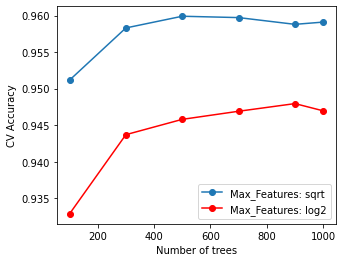

In [326]:
n_estimators = [100, 300, 500, 700, 900,1000]
CV_accuracy_score = list(means[:6])
CV_accuracy_score2 = list(means[6:])

fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(n_estimators, CV_accuracy_score, ls='-', marker='o', label="Max_Features: sqrt")
ax.plot(n_estimators, CV_accuracy_score2,color='r', ls='-', marker='o', label="Max_Features: log2")
ax.set_xlabel('Number of trees')
ax.set_ylabel('CV Accuracy');
plt.legend()

#### Fitting a Random Forest model using the parameters from CV on gray-scale input data without Sampling (Imbalanced Data set)

In [8]:
start = time.time()
model = RandomForestClassifier(n_estimators=500,max_features='sqrt')
model.fit(X_train, y_train)
end = time.time()
print("Time Elapsed : ", end-start)

Time Elapsed :  393.116464138031


#### Train Accuracy

In [9]:
train_pred = model.predict(X_train)
print("TRain accuracy for RF model is : ", accuracy_score(y_train,train_pred))
#print(confusion_matrix(y_train, train_pred))
#print(classification_report(y_train, train_pred))

TRain accuracy for RF model is :  1.0


#### Validation Accuracy 

In [10]:
val_pred = model.predict(X_test)
print("Validation accuracy for RF model is : ", accuracy_score(y_test,val_pred))
#print(confusion_matrix(y_test, val_pred))
#print(classification_report(y_test, val_pred))

Validation accuracy for RF model is :  0.9887783728640653


#### Test Accuracy

In [11]:
test_pred = model.predict(test_data_scaled)
print("Test accuracy for RF model is : ", accuracy_score(test_lbl_grp,test_pred))
print(confusion_matrix(test_lbl_grp, test_pred))
print(classification_report(test_lbl_grp, test_pred))

Test accuracy for RF model is :  0.9266033254156769
[[4120    2    0   11   26   11]
 [ 201 1253    0    7   35    4]
 [ 119    0  220    2    1   18]
 [ 199    2    0 1488   18   63]
 [  50    1    0    7 2729    3]
 [  72   14    0   36   25 1893]]
              precision    recall  f1-score   support

           1       0.87      0.99      0.92      4170
           2       0.99      0.84      0.90      1500
           3       1.00      0.61      0.76       360
           4       0.96      0.84      0.90      1770
           5       0.96      0.98      0.97      2790
           6       0.95      0.93      0.94      2040

    accuracy                           0.93     12630
   macro avg       0.95      0.86      0.90     12630
weighted avg       0.93      0.93      0.93     12630



#### Fitting a Random Forest model using the parameters from CV on gray-scale input data with Random Down Sampling 

In [12]:
start = time.time()
model2 = RandomForestClassifier(n_estimators=500,max_features='sqrt')
model2.fit(X_Sampled, y_Sampled)
end = time.time()
print("Time Elapsed : ", end-start)

Time Elapsed :  52.25768971443176


#### Train Accuracy

In [13]:
train_pred = model2.predict(X_Sampled)
print("Training accuracy for RF model is : ", accuracy_score(y_Sampled,train_pred))
#print(confusion_matrix(y_train, train_pred))
#print(classification_report(y_train, train_pred))

Training accuracy for RF model is :  1.0


#### Validation Accuracy

In [14]:
val_pred = model2.predict(X_test)
print("Vaidation accuracy for RF model is : ", accuracy_score(y_test,val_pred))
#print(confusion_matrix(y_test, val_pred))
#print(classification_report(y_test, val_pred))

Vaidation accuracy for RF model is :  0.9556235654169855


#### Test Accuracy

In [15]:
test_pred = model2.predict(test_data_scaled)
print("Test accuracy for RF model is : ", accuracy_score(test_lbl_grp,test_pred))
print(confusion_matrix(test_lbl_grp, test_pred))
print(classification_report(test_lbl_grp, test_pred))

Test accuracy for RF model is :  0.9036421219319082
[[3861   71   21  120   35   62]
 [  60 1345    1   33   52    9]
 [  59    7  275    7    0   12]
 [  98   60    2 1494   27   89]
 [  18   18    6   32 2673   43]
 [  52   52   21  120   30 1765]]
              precision    recall  f1-score   support

           1       0.93      0.93      0.93      4170
           2       0.87      0.90      0.88      1500
           3       0.84      0.76      0.80       360
           4       0.83      0.84      0.84      1770
           5       0.95      0.96      0.95      2790
           6       0.89      0.87      0.88      2040

    accuracy                           0.90     12630
   macro avg       0.88      0.88      0.88     12630
weighted avg       0.90      0.90      0.90     12630



In [16]:
### Misclassified samples in Class 1 (Speed limit)

for cls in [1,2,3,4,5,6]:
    print("Class ", cls, " misclassifications")
    class_ind = np.where(test_lbl_grp==cls)[0]

    wrong_ind = []
    for ind in class_ind:
        if test_pred[ind] != cls:
            wrong_ind.append(ind)
    print(np.unique(test_pred[wrong_ind], return_counts=True))

Class  1  misclassifications
(array([2, 3, 4, 5, 6]), array([ 71,  21, 120,  35,  62], dtype=int64))
Class  2  misclassifications
(array([1, 3, 4, 5, 6]), array([60,  1, 33, 52,  9], dtype=int64))
Class  3  misclassifications
(array([1, 2, 4, 6]), array([59,  7,  7, 12], dtype=int64))
Class  4  misclassifications
(array([1, 2, 3, 5, 6]), array([98, 60,  2, 27, 89], dtype=int64))
Class  5  misclassifications
(array([1, 2, 3, 4, 6]), array([18, 18,  6, 32, 43], dtype=int64))
Class  6  misclassifications
(array([1, 2, 3, 4, 5]), array([ 52,  52,  21, 120,  30], dtype=int64))


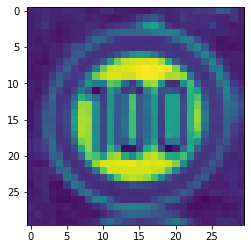

In [423]:
plt.imshow(test_data_scaled[121,:].reshape(30,30))

#### ROC / AUC

In [17]:
y_score = model2.predict_proba(test_data_scaled)

# structures
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(0,6):
    fpr[i], tpr[i], _ = roc_curve((test_lbl_grp==i+1), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

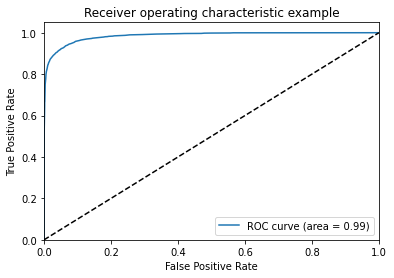

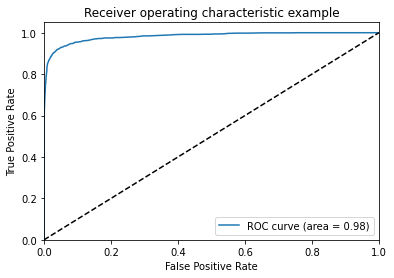

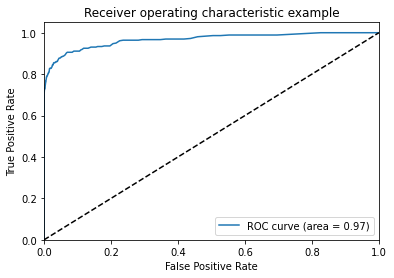

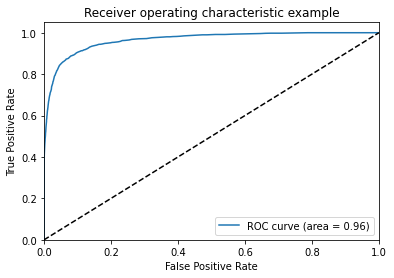

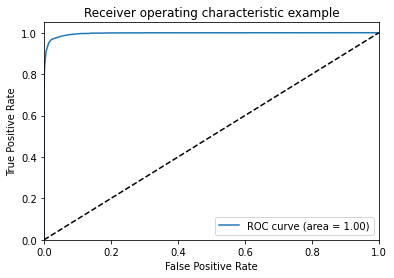

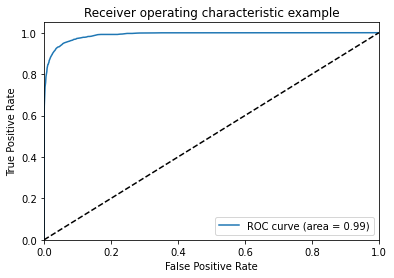

In [18]:
for i in range(0,6):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#### Fitting Random forest model including all 43 classes like the original data

In [19]:
## Splitting into test/validation
X_train, X_test, y_train, y_test = train_test_split(train_data_scaled,train_labels, test_size=0.2, random_state = 24)

rus = RandomUnderSampler(random_state=0)
X_Sampled, y_Sampled = rus.fit_resample(X_train, y_train)

In [20]:
'''
TAKES VERY LONG SO NOT RUNNING THIS

start = time.time()
# define models and parameters
model = RandomForestClassifier()
n_estimators = [100, 300, 500, 700, 900]
max_features = ['sqrt']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_split = [10,20,30,40,50]
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,min_samples_split=min_samples_split)
#cv = RepeatedStratifiedKFold(n_splits=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

end = time.time()
print("Time Elapsed : ", end-start)

'''

'\nTAKES VERY LONG SO NOT RUNNING THIS\n\nstart = time.time()\n# define models and parameters\nmodel = RandomForestClassifier()\nn_estimators = [100, 300, 500, 700, 900]\nmax_features = [\'sqrt\']\nmax_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]\nmin_samples_split = [10,20,30,40,50]\n# define grid search\ngrid = dict(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,min_samples_split=min_samples_split)\n#cv = RepeatedStratifiedKFold(n_splits=5, random_state=1)\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring=\'accuracy\',error_score=0)\ngrid_result = grid_search.fit(X_train, y_train)\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r"

#### Fitting a Random forest model with all data (Not Sampled) for 43 classes

In [21]:
start = time.time()
rf_model = RandomForestClassifier(n_estimators=700,max_features='sqrt')
rf_model.fit(X_train, y_train)
end = time.time()
print("Time Elapsed : ", end-start)

Time Elapsed :  738.096113204956


In [22]:
val_pred = rf_model.predict(X_test)
print("Vaidation accuracy for RF model is : ", accuracy_score(y_test,val_pred))
#print(confusion_matrix(y_test, val_pred))
#print(classification_report(y_test, val_pred))

Vaidation accuracy for RF model is :  0.9809997449630197


In [23]:
test_pred = rf_model.predict(test_data_scaled)
print("Test accuracy for RF model is : ", accuracy_score(test_labels,test_pred))
print(confusion_matrix(test_labels, test_pred))
print(classification_report(test_labels, test_pred))

Test accuracy for RF model is :  0.7712589073634204
[[ 14  30   2 ...   0   0   0]
 [  0 614  45 ...   0   0   0]
 [  0  35 602 ...   0   0   0]
 ...
 [  0   1   0 ...  56   0   0]
 [  0   0   0 ...   0  36   0]
 [  0   0   0 ...   0  25  37]]
              precision    recall  f1-score   support

           0       1.00      0.23      0.38        60
           1       0.73      0.85      0.79       720
           2       0.62      0.80      0.70       750
           3       0.65      0.66      0.65       450
           4       0.74      0.78      0.76       660
           5       0.58      0.63      0.60       630
           6       0.75      0.51      0.61       150
           7       0.66      0.74      0.70       450
           8       0.59      0.45      0.51       450
           9       0.92      0.84      0.88       480
          10       0.84      0.93      0.88       660
          11       0.85      0.95      0.90       420
          12       0.83      0.91      0.87       690

### END